## Introduction ##

This notebook is designed to simulate the comb percolation process.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Simulation ##

In [2]:
#Function for offsetting shape associated to each cell
def get_offsets(cell, shape):
    offset_cells = []
    for shape_cell in shape:
        #For each cell in the shape, take the right coordinate from the shape, take the sleep coordinate from both the shape and the cell
        offset_cells.append(tuple(np.array([shape_cell[0], shape_cell[1]])+np.array([0, cell[1]])))
    return offset_cells

In [3]:
#This function takes in an unordered array of cells and partitions it into an array of diagonals. 
def partition_into_layers(newly_invaded_cells):
    flat_list = []
    num_layers = 0
    for list in newly_invaded_cells:
        for element in list:
            #Find the largest layer in the set of newly invaded cells
            if element[0]+element[1] > num_layers:
                num_layers = element[0]+element[1]
            flat_list.append(element)

    invaded_layers = []
    
    for layer in range(num_layers+1):
        layer_i = []
        for cell in flat_list:
            #Only add a cell if it's not already in the layer, so we are not keeping repeat cells
            if cell[0]+cell[1] == layer and (cell[0], cell[1]) not in layer_i:
                layer_i.append((cell[0], cell[1]))
        invaded_layers.append(layer_i)   
    return invaded_layers

In [4]:
#This function takes in a set of invaded cells separated into diagonals and a sleep rate, 
#and returns the instruction stacks at the spine and tooth as well as an array of newly invaded cells 
#after one step of the comb percolation process. The returned array has 3 components, the first two are the instruction stack strings
#and the third is an array of newly invaded cells, separated into diagonals already
def run_comb_percolation_step(invaded_cells, sleep_rate):
    tooth_instruction_stack = ''
    spine_instruction_stack = ''
    newly_invaded_cells = []
    #Assumes invaded_cells is an array of diagonals containing cells
    num_layers = len(invaded_cells)
    shape_array = []
    r_counter = 0
    for i in range(num_layers):
        #Each shape starts with the 0th cell. This is if 
        shape_i = []
        #Number of U's between successive L's 
        u_i = np.random.geometric(1/2) - 1
        #Counting the spaces to need one more than the number of U's
        for j in range(u_i+1):
            #Inheritance
            if i == 0 or j != 0:
                tooth_sleep_indicator = 0
                l = random.random()
                #Check if there is a sleep before the next down instruction in the tooth stack
                if l < sleep_rate/(1+sleep_rate):
                    tooth_instruction_stack += 'S'
                    tooth_sleep_indicator = 1
                tooth_instruction_stack += 'D'
            #Number of R's between sucessive U's
            r_j = np.random.geometric(2/3)-1
            #Counting the spaces so need one more than the number of R's
            for k in range(r_j+1):
                #Dont want duplicate cells for clarity
                if (r_counter, 0) not in shape_i:
                    shape_i.append((r_counter, 0))
                if (r_counter, tooth_sleep_indicator) not in shape_i:
                    shape_i.append((r_counter, tooth_sleep_indicator))
            
                spine_sleep_indicator = 0
                #Check if there is a sleep instruction in the spine stack before the next move instruction
                l = random.random()
                if l < sleep_rate/(1+sleep_rate):
                    spine_sleep_indicator = 1
                    spine_instruction_stack += 'S'
                    
                if (r_counter, spine_sleep_indicator) not in shape_i:
                    shape_i.append((r_counter, spine_sleep_indicator))
                if (r_counter, spine_sleep_indicator+tooth_sleep_indicator) not in shape_i:
                    shape_i.append((r_counter, spine_sleep_indicator + tooth_sleep_indicator))
                
                if k != 0:
                    spine_instruction_stack += 'R'
                #Increment the number of R's which have been used so far
                r_counter += 1
            if j != 0:
                spine_instruction_stack += 'U'
            #Overcounted the number of R's, so subtract one
            r_counter -= 1
        shape_array.append(shape_i)
        spine_instruction_stack += 'L'
    
    for i, diagonal in enumerate(invaded_cells):
        shape_i = shape_array[i]
        for cell in diagonal:
            offset_cells = get_offsets(cell, shape_i)
            newly_invaded_cells.append(offset_cells)
    
    newly_invaded_cells = partition_into_layers(newly_invaded_cells)
    return [tooth_instruction_stack, spine_instruction_stack, newly_invaded_cells]

## Running Simulations ## 

In [5]:
#Change if you want different parameters
num_iterations = 25
sleep_rate = 1

#Begin with the origin invaded, double [[]] as this is an array of diagonals (which are arrays of cells in the diagonal)
invaded_cells = [[(0,0)]]

for i in range(num_iterations):
    print("Iteration: "+str(i), end="\r")
    #The output of run_comb_percolation_step also includes the instruction stacks at the spine and tooth, we just throw them away for now
    [tooth_instruction_stack, spine_instruction_stack, invaded_cells] = run_comb_percolation_step(invaded_cells, sleep_rate)

## Plotting ##

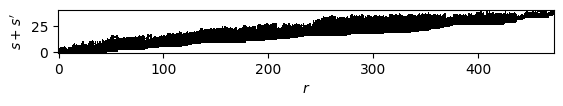

In [6]:
#Formatting, the invaded_cells array is a list of diagonals, so we are unwrapping this into just coordinates
points = [pt for diag in invaded_cells for pt in diag]

# Find max x and y to size the array
max_x = max(p[0] for p in points)
max_y = max(p[1] for p in points)

# Create 2D numpy array with ones
pixel_array = np.ones((max_y + 1, max_x + 1))  # shape = (rows=y, cols=x)

# Fill array at each coordinate with 0, want filled cells to be black and empty cells to be white
for x, y in points:
    pixel_array[y, x] = 0  # Note: y is row, x is column

plt.figure()
plt.imshow(pixel_array, cmap='gray', interpolation='nearest', origin='lower')
plt.xlabel("$r$")
plt.ylabel("$s+s'$")
plt.savefig('CombPercolationPlot25.png', bbox_inches='tight', dpi=300)
plt.show()